In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load the datasets
minmax_onehot_df = pd.read_csv('./3-minmax_onehot_1_1.csv')
target_df = pd.read_csv('./target.csv')

# Extract the target variable
y = target_df['LET_IS']

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(minmax_onehot_df, y_encoded, test_size=0.1, random_state=43)

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=8, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test)

# Calculate the AUC score for each class
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f'Multi-class AUC score: {auc:.4f}')
# print(y_pred_proba)


Multi-class AUC score: 0.7483


In [27]:
y_pred_proba # xgboost 가 예측한 prob

array([[8.6382556e-01, 1.2063354e-01, 4.3781037e-03, ..., 5.0830643e-04,
        7.3170750e-03, 1.1222532e-03],
       [9.9858713e-01, 1.6529867e-04, 3.8169532e-05, ..., 1.7660146e-05,
        6.9344933e-05, 7.8195654e-04],
       [9.9155444e-01, 1.9368653e-03, 8.1104122e-04, ..., 3.6640151e-04,
        7.1078731e-04, 3.1024825e-03],
       ...,
       [9.9821788e-01, 8.2436149e-05, 2.2127038e-05, ..., 1.3311678e-03,
        5.5357359e-05, 1.4525258e-04],
       [9.7754228e-01, 7.6543731e-03, 8.8983483e-04, ..., 3.3380107e-03,
        1.6275877e-03, 1.5508143e-03],
       [9.9026233e-01, 1.0805127e-03, 2.2133625e-04, ..., 5.9500843e-04,
        1.1794759e-03, 5.6877555e-03]], dtype=float32)

In [ ]:
y_pred_proba # catboost 가 예측한 prob

In [ ]:
# 0.3 * (xg_y_pred_proba) + (1 - 0.3) * (cat_y_pred_proba)
# 간단한ensemble 기법
# x_train y_train 같은거써야함(cat,xg에대해서)
argmax 하기 -> prob 제일높은거 

In [6]:
y_pred_proba.shape

(170, 8)

In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import warnings

warnings.filterwarnings('ignore')

# Load the datasets
minmax_onehot_df = pd.read_csv('./3-minmax_onehot_1_1.csv')
target_df = pd.read_csv('./target.csv')

# Extract the target variable
y = target_df['LET_IS']

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(minmax_onehot_df, y_encoded, test_size=0.2, random_state=42)

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=8, eval_metric='mlogloss', use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 6, 9, 15, 30],
    'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.1, 0.2],
    # 'subsample': [0.8, 1.0],
    # 'colsample_bytree': [0.8, 1.0],
    # 'reg_alpha': [0, 0.1, 1],
    # 'reg_lambda': [1, 1.5, 2]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc_ovr', cv=3, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Calculate the AUC score for each class
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f'Multi-class AUC score: {auc:.4f}')

# Calculate the F1 scores
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'F1 Micro score: {f1_micro:.4f}')
print(f'F1 Macro score: {f1_macro:.4f}')


Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1}
Multi-class AUC score: 0.7865
F1 Micro score: 0.8735
F1 Macro score: 0.1958


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1}
Multi-class AUC score: 0.8263
F1 Micro score: 0.8824
F1 Macro score: 0.2718


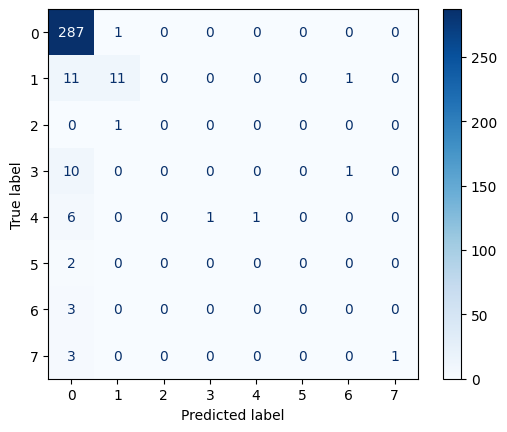

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Load the datasets
minmax_onehot_df = pd.read_csv('./3-minmax_label_1_1.csv')
target_df = pd.read_csv('./target.csv')

# Extract the target variable
y = target_df['LET_IS']

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(minmax_onehot_df, y_encoded, test_size=0.2, random_state=42)

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=8, eval_metric='mlogloss', use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 6, 9, 15],
    'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.1, 0.2],
    # 'subsample': [0.8, 1.0],
    # 'colsample_bytree': [0.8, 1.0],
    # 'reg_alpha': [0, 0.1, 1],
    # 'reg_lambda': [1, 1.5, 2]
}
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc_ovr', cv=3, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Calculate the AUC score for each class
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f'Multi-class AUC score: {auc:.4f}')

# Calculate the F1 scores
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'F1 Micro score: {f1_micro:.4f}')
print(f'F1 Macro score: {f1_macro:.4f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found for ./preprocessed_data/3-robust_no_encoding_1_1.csv:  {'learning_rate': 0.2}
Multi-class AUC score for ./preprocessed_data/3-robust_no_encoding_1_1.csv: 0.8271
F1 Micro score for ./preprocessed_data/3-robust_no_encoding_1_1.csv: 0.8853
F1 Macro score for ./preprocessed_data/3-robust_no_encoding_1_1.csv: 0.2290


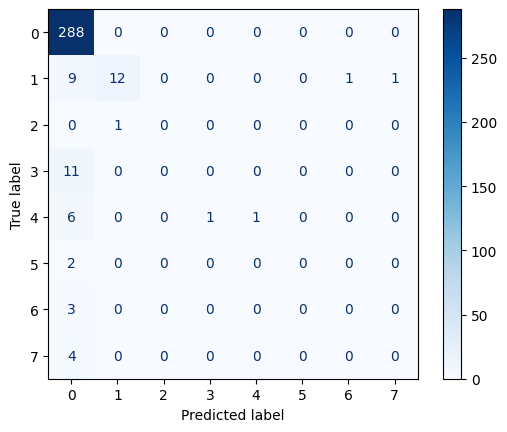

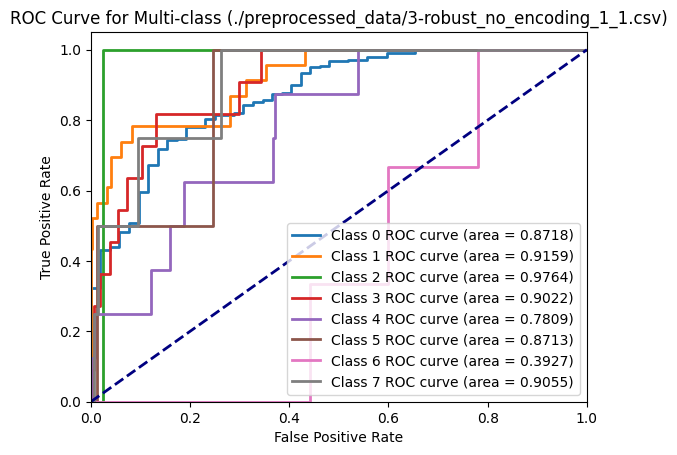

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_model(scaled_file, target_file):
    # Load the datasets
    scaled_df = pd.read_csv(scaled_file)
    target_df = pd.read_csv(target_file)

    if 'Unnamed: 0' in scaled_df.columns:
        scaled_df = scaled_df.drop(columns=['Unnamed: 0'])
        
    # Extract the target variable
    y = target_df['LET_IS']

    # Encode the categorical target variable if needed
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_encoded, test_size=0.2, random_state=42)

    # Create the XGBoost model
    xgb_model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, num_class=8)

    # Define the parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.02, 0.2, 0.3, 0.5],
        # 'max_depth': [3, 6, 9, 15],
        # 'min_child_weight': [1, 3, 5],
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc_ovr', cv=3, verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Display the best parameters
    print(f"Best parameters found for {scaled_file}: ", grid_search.best_params_)

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = best_model.predict(X_test)

    # Calculate the AUC score (One-vs-Rest)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f'Multi-class AUC score for {scaled_file}: {auc_score:.4f}')

    # Calculate the F1 scores
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f'F1 Micro score for {scaled_file}: {f1_micro:.4f}')
    print(f'F1 Macro score for {scaled_file}: {f1_macro:.4f}')

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(8):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multi-class ({scaled_file})')
    plt.legend(loc='lower right')
    plt.show()

# # List of preprocessed files - no encoding (about categorical variable)
scaled_files = [
    # './preprocessed_data/3-minmax_no_encoding_1_1.csv',
    './preprocessed_data/3-robust_no_encoding_1_1.csv',
    # './preprocessed_data/3-log_no_encoding_1_1.csv',
    # './preprocessed_data/3-normalize_no_encoding_1_1.csv',
    # './preprocessed_data/3-maxabs_no_encoding_1_1.csv',
    # './preprocessed_data/3-zscore_no_encoding_1_1.csv'
]

# # list of preprocessed files = one-hot encoding(about caregorical variable)
# scaled_files = [
#     './preprocessed_data/3-minmax_onehot_encoding_1_1.csv',
#     './preprocessed_data/3-robust_onehot_encoding_1_1.csv',
#     './preprocessed_data/3-log_onehot_encoding_1_1.csv',
#     './preprocessed_data/3-normalize_onehot_encoding_1_1.csv',
#     './preprocessed_data/3-maxabs_onehot_encoding_1_1.csv',
#     './preprocessed_data/3-zscore_onehot_encoding_1_1.csv'
# ]
# Target file
target_file = './rawdata/target.csv'

# Run the model for each scaled file
for i in scaled_files:
    run_model(i, target_file)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found for ./preprocessed_data/3-robust_no_encoding_1_3.csv:  {'learning_rate': 0.2}
Multi-class AUC score for ./preprocessed_data/3-robust_no_encoding_1_3.csv: 0.9822
F1 Micro score for ./preprocessed_data/3-robust_no_encoding_1_3.csv: 0.9409
F1 Macro score for ./preprocessed_data/3-robust_no_encoding_1_3.csv: 0.5750


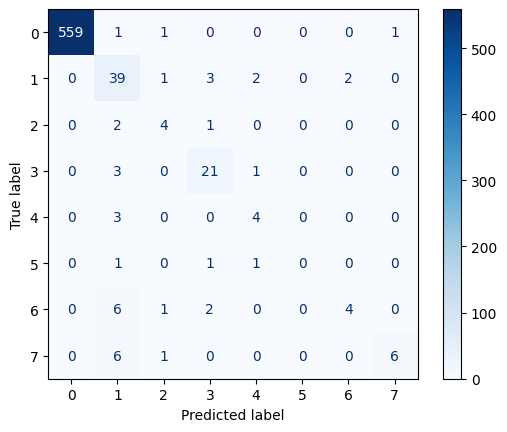

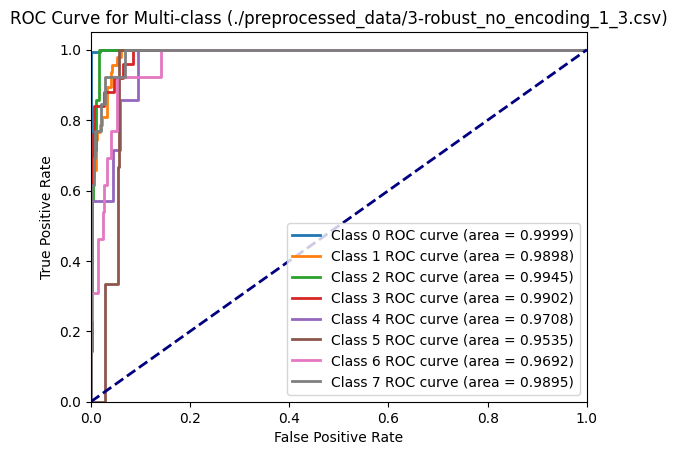

In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_model(scaled_file, target_file):
    # Load the datasets
    scaled_df = pd.read_csv(scaled_file)
    target_df = pd.read_csv(target_file)

    if 'Unnamed: 0' in scaled_df.columns:
        scaled_df = scaled_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in target_df.columns:
        target_df = target_df.drop(columns=['Unnamed: 0'])
        
    # Extract the target variable
    y = target_df['LET_IS']

    # Encode the categorical target variable if needed
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_encoded, test_size=0.2, random_state=42)

    # Create the XGBoost model
    xgb_model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, num_class=8)

    # Define the parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.02, 0.2, 0.3, 0.5],
        # 'max_depth': [3, 6, 9, 15],
        # 'min_child_weight': [1, 3, 5],
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc_ovr', cv=3, verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Display the best parameters
    print(f"Best parameters found for {scaled_file}: ", grid_search.best_params_)

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = best_model.predict(X_test)

    # Calculate the AUC score (One-vs-Rest)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f'Multi-class AUC score for {scaled_file}: {auc_score:.4f}')

    # Calculate the F1 scores
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f'F1 Micro score for {scaled_file}: {f1_micro:.4f}')
    print(f'F1 Macro score for {scaled_file}: {f1_macro:.4f}')

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(8):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multi-class ({scaled_file})')
    plt.legend(loc='lower right')
    plt.show()

# Specific scaled file
scaled_file = './preprocessed_data/3-robust_no_encoding_1_3.csv'

# Target file
target_file = './rawdata/1_3y.csv'

# Run the model for the specified scaled file
run_model(scaled_file, target_file)


# ABOUT BINARY CLASSIFICATION

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found for ./preprocessed_data/3-robust_no_encoding_1_1.csv:  {'learning_rate': 0.2}
AUC score for ./preprocessed_data/3-robust_no_encoding_1_1.csv: 0.8627
F1 Micro score for ./preprocessed_data/3-robust_no_encoding_1_1.csv: 0.8941
F1 Macro score for ./preprocessed_data/3-robust_no_encoding_1_1.csv: 0.7450


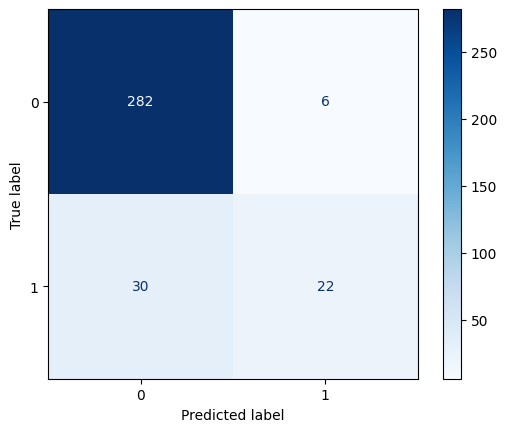

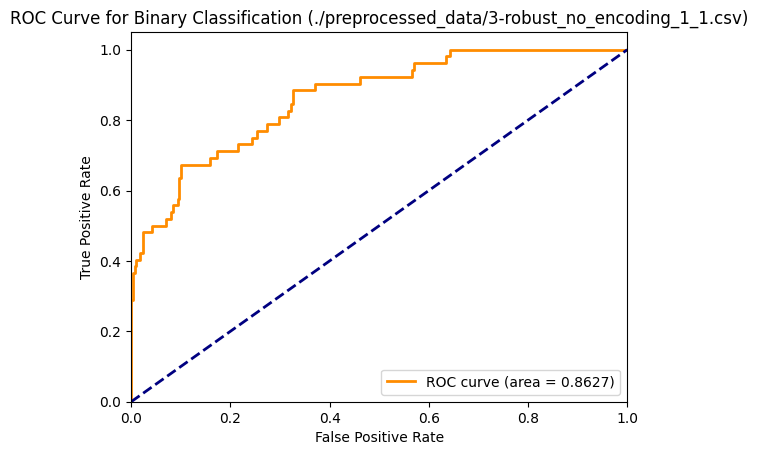

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_model(scaled_file, target_file):
    # Load the datasets
    scaled_df = pd.read_csv(scaled_file)
    target_df = pd.read_csv(target_file)

    if 'Unnamed: 0' in scaled_df.columns:
        scaled_df = scaled_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in target_df.columns:
        target_df = target_df.drop(columns=['Unnamed: 0'])
        
    # Extract the target variable
    y = target_df['LET_IS_C']

    # Encode the categorical target variable if needed
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_encoded, test_size=0.2, random_state=42)

    # Create the XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

    # Define the parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.02, 0.2, 0.3, 0.5],
        # 'max_depth': [3, 6, 9, 15],
        # 'min_child_weight': [1, 3, 5],
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Display the best parameters
    print(f"Best parameters found for {scaled_file}: ", grid_search.best_params_)

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC score for {scaled_file}: {auc_score:.4f}')

    # Calculate the F1 scores
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f'F1 Micro score for {scaled_file}: {f1_micro:.4f}')
    print(f'F1 Macro score for {scaled_file}: {f1_macro:.4f}')

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Binary Classification ({scaled_file})')
    plt.legend(loc='lower right')
    plt.show()

# Specific scaled file
scaled_file = './preprocessed_data/3-robust_no_encoding_1_1.csv'

# Target file
target_file = './rawdata/target_c.csv'

# Run the model for the specified scaled file
run_model(scaled_file, target_file)
